# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import t
from numpy.random import seed
plt.rcParams['figure.figsize'] = (4, 4)

medical = pd.read_csv('insurance2.csv')

In [2]:
medical.shape

(1338, 8)

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__

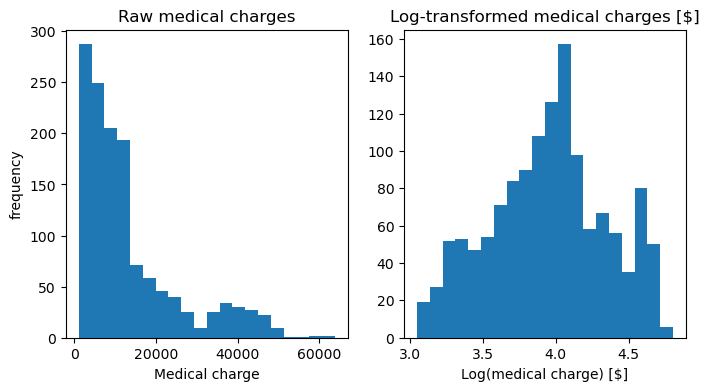

In [4]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].hist(medical.charges, bins=20)
ax[0].set_xlabel('Medical charge')
ax[0].set_ylabel('frequency')
ax[0].set_title('Raw medical charges')
ax[1].hist(np.log10(medical.charges), bins=20)
ax[1].set_xlabel('Log(medical charge) [$]')
ax[1].set_title('Log-transformed medical charges [$]')
plt.show()

In [5]:
print(f'The mean and standard deviation of medical charges are {np.mean(medical.charges):.1f} and {np.std(medical.charges):.1f}, respectively.')

The mean and standard deviation of medical charges are 13270.4 and 12105.5, respectively.


The raw distribution of medical charges is substantially right-skewed, making the mean and standard deviation insufficient for accurately summarizing it. However, after log transformation, the distribution appears to more closely resemble a normal distribution. 

__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__ Given that the log-transformed distribution closely resembles a normal distribution, a one-sample t-test can be used to test the hypothesis that '*the mean charge decresaed to $12,000 or lower*'. Alternatively, a bootstrap hypothesis test can be performed, as it does not rely on the assumption of normality.

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A:__ A one-sided interval is appropriate here, as we are only interested in whether the average charge has decreased below a certain threshold, rather than the absolute change. We can conduct the following tests:

1) bootstrap hypothesis test
2) t-test
 

In [6]:
# 1. Bootstrap hypothesis test

seed(47)
def medical_charge_sampler(data, n):
    return np.random.choice(data, n)

# take your samples here
def experiment(data, ntrials, sample_size):
    means = np.empty(ntrials)
    for ix  in range(ntrials):
        means[ix] = np.mean(medical_charge_sampler(data, sample_size))
    return means


In [7]:
translated = medical.charges - np.mean(medical.charges) + 12000
means = experiment(translated, 10000, medical.charges.count())

observed = np.mean(medical.charges)

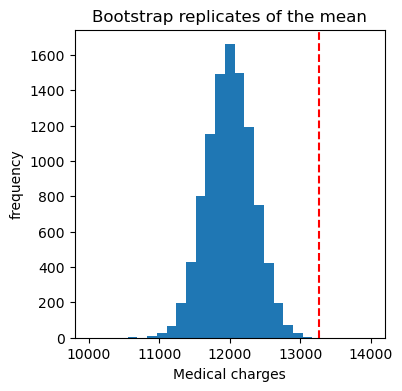

In [8]:
plt.subplots()
plt.hist(means, bins=np.linspace(10000,14000,30))
plt.axvline(observed, color='r', linestyle='--')
plt.xlabel('Medical charges')
plt.ylabel('frequency')
plt.title('Bootstrap replicates of the mean')
plt.show()

In [9]:
conf_int = np.percentile(means,[0.,95])
print(f'If the hypothesis that the mean medical charge has decreased to $12,000 or lower is true, \
then we are 95% confident that the true mean lies below the critical value ${conf_int[1]:.1f}. \
The observed value {np.mean(medical.charges):.1f} is fairly higher than this value.')

If the hypothesis that the mean medical charge has decreased to $12,000 or lower is true, then we are 95% confident that the true mean lies below the critical value $12542.9. The observed value 13270.4 is fairly higher than this value.


In [10]:
# 2. t-test

log_translated = np.log10(medical.charges) - np.mean(np.log10(medical.charges)) + np.log10(12000)
log_std = np.std(log_translated)
log_mean =np.mean(log_translated)
print(f' log mean: {log_mean:.3f}, log std: {log_std:.3f}')

 log mean: 4.079, log std: 0.399


In [11]:
ct=t.ppf(q=0.95,df=medical.charges.count()-1)
print(f'The critical t value for 95% Margin of error is {ct:1.2f}')

print(f'The corresponding confidence interval of the mean is \
[0, {pow(10, np.log10(12000)+ ct*log_std/np.sqrt(medical.charges.count()) ):.2f}] cm.')


The critical t value for 95% Margin of error is 1.65
The corresponding confidence interval of the mean is [0, 12506.75] cm.


**Recommendation for the administrator**: The results from both the bootstrap and t-test methods consistently indicate that we can reject the hypothesis that the average medical charge has decreased to $12,000 or lower. The administrator need not be concerned, based on the current findings. 


The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A:__ \
The null hypothesis: People with insurance are charged the same amount as those without insurance. \
The alternative hypothesis: People with insurance are charged a different amount, e.g. by the difference in the sample means, as those without insurance.\
The two-sample t-test relies on the assumptions that both populations are normally distributed and have equal, though unknown, variances, which are estimated from the sample data.


In [12]:
insured  = medical[medical.insuranceclaim >0].charges.to_numpy()
uninsured = medical[medical.insuranceclaim == 0].charges.to_numpy()

n0,n1 =  insured.shape[0], uninsured.shape[0]
print('n0 (insured): ', n0, ', n1 (uninsured): ', n1)

mean0, mean1 = np.mean(insured),np.mean(uninsured)
print(f'mean0 (insured): {mean0:.1f}, mean1 (uninsured): {mean1:.1f}')

std0,std1 = np.std(insured),np.std(uninsured)
print(f'std0 (insured): {std0:.1f}, std1 (uninsured): {std1:.1f}')

sp =np.sqrt( ((n0-1)*std0**2 + (n1-1)*std1**2) / (n0+n1-2) )
print(f'sp: {sp:.1f}')


n0 (insured):  783 , n1 (uninsured):  555
mean0 (insured): 16423.9, mean1 (uninsured): 8821.4
std0 (insured): 14037.0, std1 (uninsured): 6440.7
sp: 11512.3


__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

In [13]:
# Null hypothesis test
 # manual
t_value = (mean0-mean1)/sp/np.sqrt(1/n0+1/n1)
print(f't : {t_value:.1f}')

p_value = 1-t.cdf(t_value, df=1336)
print(f'p-value: {p_value:.3f}')

t : 11.9
p-value: 0.000


In [14]:
 # using scipy.stats
t_value = stats.ttest_ind(insured,uninsured)
print(f't : {t_value.statistic:.1f}, p-value: {t_value.pvalue:.3f}')

t : 11.9, p-value: 0.000


**Conclusion**: Both methods consistently lead to the rejection of the null hypothesis. The difference observed in the sample means is statistically significant.

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__ It appears that SciPy does not provide a one-sample z-test, likely because the population standard deviation is rarely known in practice.

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test